In [165]:
from kafka import KafkaConsumer
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score,recall_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [166]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)


In [167]:
for m in consumer:
    dd = m.value
    break

In [168]:
k_dataset= pd.read_csv("Static_dataset.csv")
from pandas.util import hash_pandas_object
categoric = k_dataset.select_dtypes(include=['object']).copy()
numerical = k_dataset.select_dtypes(include=['int64','float64']).copy()
def hashing(df):
    for col in df.columns :
        df[col] = hash_pandas_object(df[col])
    return df
categoric = hashing(categoric)
k_dataset=pd.concat([categoric,numerical],axis=1)

In [169]:
k_dataset

,timestamp,longest_word,sld,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
0,13143242955146178578,12818595333635098865,1436061903013436886,27,10,0,10,11,2.570417,6,6,7,3.666667,14,1,1
1,2577386964918736430,17185745172638414508,16487103021445981531,27,10,0,10,11,2.767195,6,6,7,3.666667,14,1,1
2,219530798504705711,17979476933330425403,8782042356081258380,26,9,0,10,10,2.742338,6,6,7,3.500000,13,1,0
3,2202385798199089757,8625786489483146881,14213111700542671718,27,10,0,10,11,2.570417,6,6,7,3.666667,14,1,1
4,13599999059469247330,6933423371777200487,6933423371777200487,15,9,0,11,0,2.929439,4,3,5,4.333333,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,4635147120335315575,17593087732653107179,1074112825213617825,18,3,0,16,0,2.338623,2,3,10,5.333333,14,1,0
268070,694724741529077594,6543177446356295113,11629204487744685214,27,10,0,10,11,2.767195,6,6,7,3.666667,14,1,0
268071,13076708599487200848,1392224066739923824,11214114670944286487,27,10,0,10,11,2.767195,6,6,7,3.666667,14,1,1
268072,4906493388405613576,6819429491188426835,10122129679838215532,16,0,0,14,0,3.249687,2,2,13,7.500000,14,0,0


In [170]:
k_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  uint64 
 1   longest_word      268074 non-null  uint64 
 2   sld               268074 non-null  uint64 
 3   FQDN_count        268074 non-null  int64  
 4   subdomain_length  268074 non-null  int64  
 5   upper             268074 non-null  int64  
 6   lower             268074 non-null  int64  
 7   numeric           268074 non-null  int64  
 8   entropy           268074 non-null  float64
 9   special           268074 non-null  int64  
 10  labels            268074 non-null  int64  
 11  labels_max        268074 non-null  int64  
 12  labels_average    268074 non-null  float64
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

In [171]:
def get_1000_record(itr):
    list_with_1000_record=[]
    i=0
    for m in consumer:
        
        if i <1000:
            #print(f"recored {i+1} :", m.value)
            list_with_1000_record.append(m.value)
            i=i+1
        else:
            break
    print(f"Window {itr}")
    return list_with_1000_record              
    

In [172]:
column_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def prepare_data( data):
    df=pd.DataFrame()
    list_of_row=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_row.append(row)
    df=pd.DataFrame(list_of_row)
    df.columns=column_names
    return df
    

In [173]:
def data_cleaning(data):
    data['longest_word'] = data['longest_word'].replace(r'(([a-z]+)|([A-Z]+)|'')',2, regex=True)
    data['longest_word'].fillna(2,inplace=True)
    data['sld'] = data['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',192, regex=True)
    data['sld']=data['sld'] .astype('int') 
#     data[['FQDN_count','subdomain_length']] = data[['FQDN_count','subdomain_length']].replace(r'(([a-z]+)|([A-Z]+)|'')',2, regex=True)
    data.drop('timestamp', inplace=True, axis=1)
    return data.astype('float')

In [174]:
def retrain_model(data):
    X= data.iloc[:,:-1]
    y= data.iloc[:,-1]
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=False)
    X_train_MI, X_test_MI=select_mutual_info(X_train, y_train, X_test)
    model = DecisionTreeClassifier()
    model.fit(X_train_MI, y_train)

    return model

In [175]:
def select_mutual_info(X_train, y_train, X_test):
    feature_selection = SelectKBest(score_func=mutual_info_classif, k=10)
    feature_selection.fit(X_train, y_train)
    X_train_MI = feature_selection.transform(X_train)
    X_test_MI = feature_selection.transform(X_test)
    return X_train_MI, X_test_MI


In [176]:
static_model = Dynamic_model= joblib.load(open('DTC_model', 'rb'))
x=y=2

C:\Users\mm\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [181]:
list_of_f1score_Dynmaic_model=[]
list_of_f1score_static_model=[]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for itr in range(267):
    new_dataset = get_1000_record(itr+1)
    new_dataset =  prepare_data(new_dataset)
    new_dataset =  data_cleaning(new_dataset)
    k_dataset=k_dataset.append(new_dataset)
    X_1= new_dataset.iloc[:,:-1]
    y= new_dataset.iloc[:,-1]
    X = scaler.fit_transform(X_1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=False)
    X_train_MI, X_test_MI=select_mutual_info(X_train, y_train, X_test)
    model=Dynamic_model.fit(X_train_MI,y_train)
    Dy_pred=model.predict(X_test_MI)
    D_f1_score=f1_score(y_test,Dy_pred)
    D_Recall = recall_score(y_test,Dy_pred)
    print(f"f1-score of Dynamic Model without retrain = {D_f1_score*100}%")
    print(f"Recall of Dynamic Model without retrain = {D_Recall*100}%")
    
    if D_f1_score < 0.89 :

        print(" The model will be trained on the new data")
        Dynamic_model=retrain_model(new_dataset)
        Dy_pred=Dynamic_model.predict(X_test_MI)
        D_f1_score=f1_score(y_test,Dy_pred)
        D_Recall = recall_score(y_test,Dy_pred)
        print(f"f1-score of Dynamic Model after retrain = {D_f1_score*100}%")
        print(f"Recall of Dynamic Model after retrain = {D_Recall*100}%")
    else:
        break
    model_S= static_model.fit(X_train_MI,y_train)   
    Sy_pred=static_model.predict(X_test_MI)
    S_f1_score=f1_score(y_test,Sy_pred)
    S_Recall = recall_score(y_test,Sy_pred)
    print(f"f1-score of Static Model = {S_f1_score*100}%")
    print(f"Recall of Static Model = {S_Recall*100}%")
    list_of_f1score_Dynmaic_model.append(D_f1_score)
    list_of_f1score_static_model.append(S_f1_score)
    print(f"{'*'*50}")

Window 1
f1-score of Dynamic Model without retrain = 83.73333333333333%
Recall of Dynamic Model without retrain = 98.74213836477988%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 83.73333333333333%
Recall of Dynamic Model after retrain = 98.74213836477988%
f1-score of Static Model = 83.51063829787235%
Recall of Static Model = 98.74213836477988%
**************************************************
Window 2


C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Dynamic Model without retrain = 82.79569892473118%
Recall of Dynamic Model without retrain = 95.65217391304348%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 82.3529411764706%
Recall of Dynamic Model after retrain = 95.65217391304348%
f1-score of Static Model = 82.79569892473118%
Recall of Static Model = 95.65217391304348%
**************************************************
Window 3
f1-score of Dynamic Model without retrain = 83.06878306878306%
Recall of Dynamic Model without retrain = 98.74213836477988%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 83.06878306878306%
Recall of Dynamic Model after retrain = 98.74213836477988%


C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Static Model = 83.06878306878306%
Recall of Static Model = 98.74213836477988%
**************************************************
Window 4


C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Dynamic Model without retrain = 81.42493638676845%
Recall of Dynamic Model without retrain = 93.02325581395348%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 81.42493638676845%
Recall of Dynamic Model after retrain = 93.02325581395348%
f1-score of Static Model = 81.42493638676845%
Recall of Static Model = 93.02325581395348%
**************************************************
Window 5
f1-score of Dynamic Model without retrain = 85.92233009708738%
Recall of Dynamic Model without retrain = 99.43820224719101%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 85.92233009708738%
Recall of Dynamic Model after retrain = 99.43820224719101%
f1-score of Static Model = 85.92233009708738%
Recall of Static Model = 99.43820224719101%
**************************************************
Window 6
f1-score of Dynamic Model without retrain = 86.54353562005278%
Recall of Dynamic Model without retrain = 100.0%
 The model wil

C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Dynamic Model without retrain = 87.0967741935484%
Recall of Dynamic Model without retrain = 100.0%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 87.0967741935484%
Recall of Dynamic Model after retrain = 100.0%
f1-score of Static Model = 87.0967741935484%
Recall of Static Model = 100.0%
**************************************************
Window 8
f1-score of Dynamic Model without retrain = 84.12698412698413%
Recall of Dynamic Model without retrain = 98.75776397515527%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 84.12698412698413%
Recall of Dynamic Model after retrain = 98.75776397515527%
f1-score of Static Model = 84.12698412698413%
Recall of Static Model = 98.75776397515527%
**************************************************
Window 9


C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Dynamic Model without retrain = 83.55091383812011%
Recall of Dynamic Model without retrain = 99.37888198757764%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 83.55091383812011%
Recall of Dynamic Model after retrain = 99.37888198757764%
f1-score of Static Model = 83.33333333333334%
Recall of Static Model = 99.37888198757764%
**************************************************
Window 10
f1-score of Dynamic Model without retrain = 83.15217391304347%
Recall of Dynamic Model without retrain = 98.07692307692307%
 The model will be trained on the new data


C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Dynamic Model after retrain = 83.15217391304347%
Recall of Dynamic Model after retrain = 98.07692307692307%
f1-score of Static Model = 83.15217391304347%
Recall of Static Model = 98.07692307692307%
**************************************************
Window 11
f1-score of Dynamic Model without retrain = 85.86387434554975%
Recall of Dynamic Model without retrain = 100.0%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 75.05720823798626%
Recall of Dynamic Model after retrain = 100.0%
f1-score of Static Model = 85.86387434554975%
Recall of Static Model = 100.0%
**************************************************
Window 12
f1-score of Dynamic Model without retrain = 83.90501319261213%
Recall of Dynamic Model without retrain = 98.75776397515527%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 83.90501319261213%
Recall of Dynamic Model after retrain = 98.75776397515527%
f1-score of Static Model = 83.9050131926

C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Dynamic Model without retrain = 86.8421052631579%
Recall of Dynamic Model without retrain = 99.3975903614458%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 86.8421052631579%
Recall of Dynamic Model after retrain = 99.3975903614458%
f1-score of Static Model = 86.8421052631579%
Recall of Static Model = 99.3975903614458%
**************************************************
Window 14
f1-score of Dynamic Model without retrain = 84.38356164383562%
Recall of Dynamic Model without retrain = 98.08917197452229%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 84.69945355191257%
Recall of Dynamic Model after retrain = 98.72611464968153%


C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Static Model = 84.38356164383562%
Recall of Static Model = 98.08917197452229%
**************************************************
Window 15
f1-score of Dynamic Model without retrain = 86.68280871670702%
Recall of Dynamic Model without retrain = 99.44444444444444%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 86.68280871670702%
Recall of Dynamic Model after retrain = 99.44444444444444%
f1-score of Static Model = 86.68280871670702%
Recall of Static Model = 99.44444444444444%
**************************************************
Window 16


C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Dynamic Model without retrain = 88.77284595300262%
Recall of Dynamic Model without retrain = 98.26589595375722%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 88.77284595300262%
Recall of Dynamic Model after retrain = 98.26589595375722%
f1-score of Static Model = 89.06249999999999%
Recall of Static Model = 98.84393063583815%
**************************************************
Window 17
f1-score of Dynamic Model without retrain = 88.77005347593582%
Recall of Dynamic Model without retrain = 100.0%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 88.77005347593582%
Recall of Dynamic Model after retrain = 100.0%
f1-score of Static Model = 88.77005347593582%
Recall of Static Model = 100.0%
**************************************************
Window 18
f1-score of Dynamic Model without retrain = 85.9504132231405%
Recall of Dynamic Model without retrain = 100.0%
 The model will be trained on the new data
f1-sco

C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)
C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


f1-score of Dynamic Model without retrain = 87.0%
Recall of Dynamic Model without retrain = 96.66666666666667%
 The model will be trained on the new data
f1-score of Dynamic Model after retrain = 87.0%
Recall of Dynamic Model after retrain = 96.66666666666667%
f1-score of Static Model = 87.0%
Recall of Static Model = 96.66666666666667%
**************************************************
Window 20
f1-score of Dynamic Model without retrain = 90.10416666666666%
Recall of Dynamic Model without retrain = 99.42528735632183%


C:\Users\mm\AppData\Local\Temp\ipykernel_21256\4131832978.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_dataset=k_dataset.append(new_dataset)


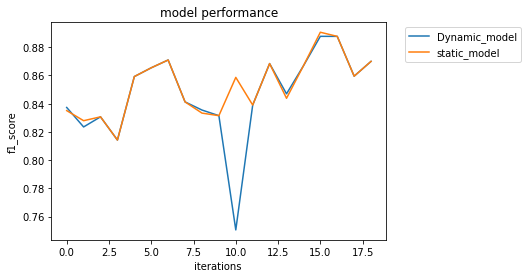

In [182]:
plt.plot(list_of_f1score_Dynmaic_model)
plt.plot(list_of_f1score_static_model)
plt.title('model performance')
plt.xlabel('iterations ')
plt.ylabel("f1_score")
plt.legend(['Dynamic_model','static_model'],bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

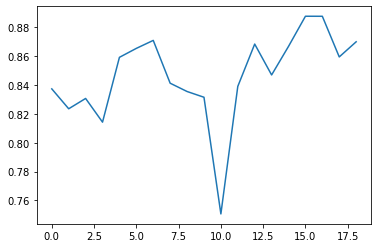

In [183]:
plt.plot(list_of_f1score_Dynmaic_model)

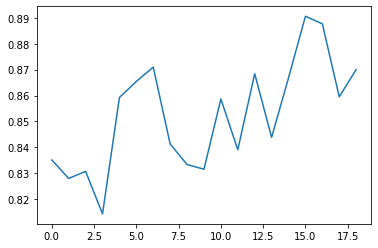

In [184]:
plt.plot(list_of_f1score_static_model)